# Methods Figure --- visualize runoff forcing (classification and Mn content)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import matplotlib
import xarray as xr
import cmocean
from matplotlib import colors
from mpl_toolkits.basemap import Basemap, cm

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# runoff period:
rf_year  = 2015
rf_month = 8    # september 

# colours:
color_glacier   = '#0873b4'
color_continent = '#d67434' 
color_other     = 'w' 
color_cont2     = '#ab5c29'
color_other2    = '#757575'

land_color         = '#a9a7a2'
land_outline_color = '#373736'

# Resolution of grid cells to show in figure:
grid_reso = 10

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#### Load files:

In [3]:
# ANHA12 river runoff forcing (http://knossos.eas.ualberta.ca/anha/anhatable.php):
rf_file = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y{rf_year}.nc','r')
model_lons = np.array(rf_file.variables['nav_lon'])
model_lats = np.array(rf_file.variables['nav_lat'])
model_river= np.array(rf_file.variables['runoff'])
rf = model_river[rf_month]

# Place NaNs where there is no runoff
rf[rf == 0]       = np.nan
model_lons[rf == 0.0] = np.nan
model_lats[rf == 0.0] = np.nan

# Mask for sub-domain:
domain_mask = np.zeros((12,model_lons.shape[0],model_lons.shape[1]))
domain_mask[:,imin:imax,jmin:jmax] = 1

In [4]:
# Runoff classification file
# 1. Glaciers
# 2. Continental
# 3. Central
ncd         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc')
river_class = np.array(ncd.variables['rclass'])

In [5]:
# ANHA12 grid mesh:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
lon_ANHA12 = np.array(mesh.variables['nav_lon'])
lat_ANHA12 = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [6]:
# Load seasonally varying river forcing:
dMn_rivers = np.zeros((12, river_class.shape[0], river_class.shape[1]))

for month in range(1,13):
    m1 = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/paper2-forcing-files/river_seasonal_m{month:02}.nc')
    dMn_rivers[month-1,:,:] = m1['dmn_rivers'].values

dMn_rivers = np.ma.masked_where(domain_mask==0, dMn_rivers)

#### Figure

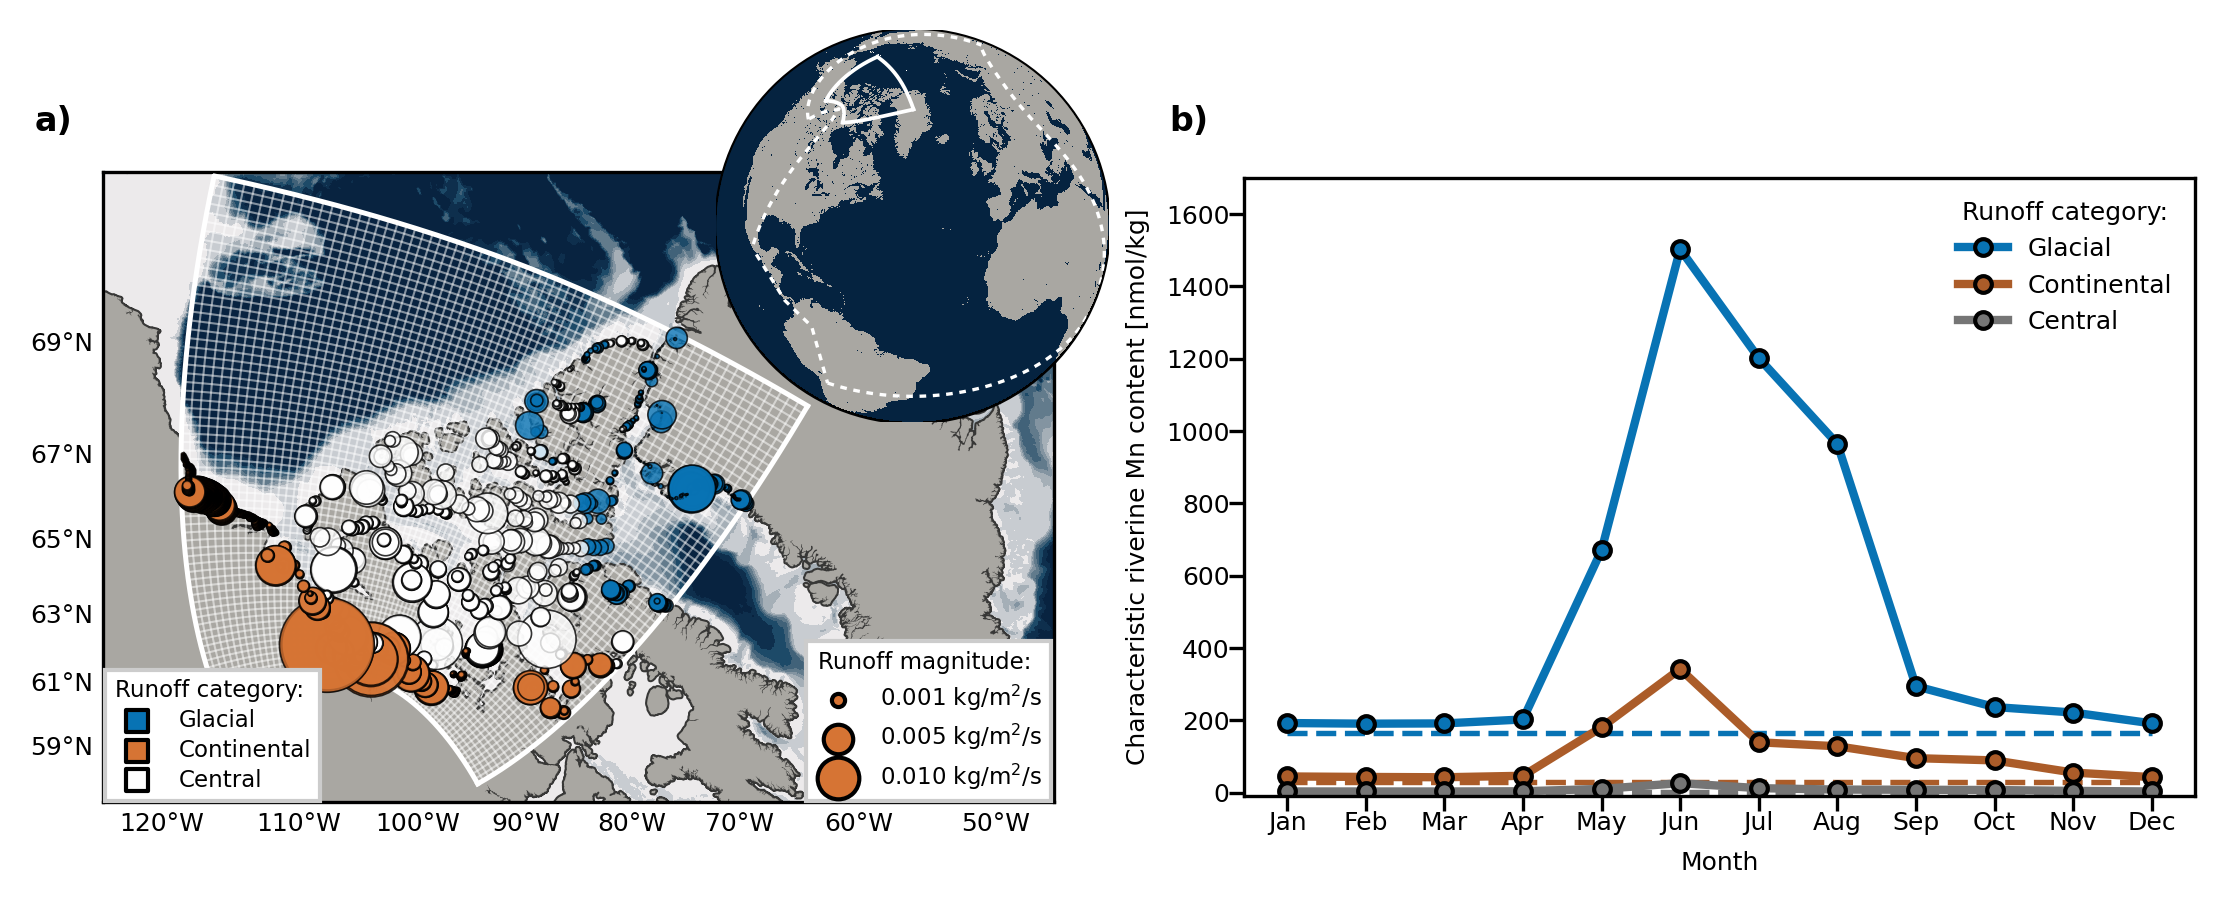

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 3.74), dpi=300)

# A) --------------
# Sub-domain map: ---------------------------------------------------------------------------
proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x_sub, y_sub  = proj1(lon_ANHA12, lat_ANHA12) 
x_rf,    y_rf = proj1(model_lons, model_lats)
bath   = proj1.contourf(x_sub, y_sub, mesh_bathy, 20, cmap=cmocean.cm.diff_r, vmin=-2000, vmax=2000, zorder=1)

proj1.plot(x_sub[imin:imax,jmax]  , y_sub[imin:imax,jmax],   'w-', lw=1.2, zorder=3)
proj1.plot(x_sub[imin:imax,jmin]  , y_sub[imin:imax,jmin],   'w-', lw=1.2, zorder=3)
proj1.plot(x_sub[imin,jmin:jmax]  , y_sub[imin,jmin:jmax],   'w-', lw=1.2, zorder=3)
proj1.plot(x_sub[imax,jmin:jmax]  , y_sub[imax,jmin:jmax],   'w-', lw=1.2, zorder=3)

proj1.plot(x_sub[imin:imax+10:grid_reso,jmin:jmax+10:grid_reso], \
           y_sub[imin:imax+10:grid_reso,jmin:jmax+10:grid_reso], 'w-', lw=0.5, zorder=2, alpha=0.5);
proj1.plot(x_sub[imin:imax+10:grid_reso,jmin:jmax+10:grid_reso].T, \
           y_sub[imin:imax+10:grid_reso,jmin:jmax+10:grid_reso].T, 'w-', lw=0.5, zorder=2, alpha=0.5);

colormap = colors.ListedColormap([color_glacier, color_continent, color_other, color_other])
proj1.scatter(x_rf[imin:imax,jmin:jmax], y_rf[imin:imax,jmin:jmax], c=river_class[imin:imax,jmin:jmax],\
              s=rf[imin:imax,jmin:jmax]*1e4, alpha=0.8, cmap=colormap, edgecolor='k', linewidths=0.4, zorder=4)

#--- Legend ----------------------
for a in ['0.001', '0.005', '0.010']:
    proj1.scatter([], [], c=color_continent, alpha=1, s=float(a)*1e4, label=f'{a} kg/m$^2$/s', \
                  edgecolors='k', zorder=4)

l1 = ax1.legend(scatterpoints=1, frameon=True, framealpha=1, labelspacing=0.4, fontsize=5.5, loc=(0.74, 0.002), \
                fancybox=False, title='Runoff magnitude: ')
l1.get_title().set_fontsize('5.5')
g  = proj1.scatter([], [], c=color_glacier  , alpha=1, s=30, edgecolors='k', zorder=4, marker='s')
c  = proj1.scatter([], [], c=color_continent, alpha=1, s=30, edgecolors='k', zorder=4, marker='s')
o  = proj1.scatter([], [], c=color_other    , alpha=1, s=30, edgecolors='k', zorder=4, marker='s')
l2 = ax1.legend([g, c, o], ['Glacial', 'Continental', 'Central'], title='Runoff category: ', \
                scatterpoints=1, frameon=True, labelspacing=0.3, fontsize=5.5, loc=(0.003, 0.002), fancybox=False, framealpha=1)
l2.get_title().set_fontsize('5.5')
ax1.add_artist(l1)

# Globe: --------------------------------------------------------------------------------------
ax3   = fig.add_axes([0.25, 0.56, 0.35, 0.35])
proj3 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax3)
proj3.drawmapboundary(fill_color='white')
proj3.drawlsmask(land_color = land_color, ocean_color="#052340", resolution = 'h',zorder=2) 
x, y  = proj3(lon_ANHA12, lat_ANHA12) 
# Sub-domain
proj3.plot(x[imin:imax,jmin], y[imin:imax,jmin], 'w-', lw=0.9, zorder=3)
proj3.plot(x[imin:imax,jmax], y[imin:imax,jmax], 'w-', lw=0.9, zorder=3)
proj3.plot(x[imin,jmin:jmax], y[imin,jmin:jmax], 'w-', lw=0.9, zorder=3)
proj3.plot(x[imax,jmin:jmax], y[imax,jmin:jmax], 'w-', lw=0.9, zorder=3)
# full domain
proj3.plot(x[460:-1:grid_reso,0]   , y[460:-1:grid_reso,0]        , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj3.plot(x[0,370:-1:grid_reso]   , y[0,370:-1:grid_reso]        , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj3.plot(x[100:-1:grid_reso,-1]  , y[100:-1:grid_reso,-1]       , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj3.plot(x[-1,0:-1:grid_reso]    , y[-1,0:-1:grid_reso]         , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
xline_add = [x[500,0], x[700,70], x[1100,0], x[0,370]]
yline_add = [y[240,-1], y[85,-80], y[80,0], y[0,370]]
proj3.plot(xline_add, yline_add, 'w--', lw=0.8, zorder=3, dashes=(2, 2))

# B) --------------
ax2.set_aspect(0.0046)
ax2.plot(months, np.ones(len(months))*164 , '--', linewidth=1.3, c=color_glacier)
ax2.plot(months, np.ones(len(months))*29.8, '--', linewidth=1.3, c=color_cont2)
ax2.plot(months, np.ones(len(months))*2.2 , '--', linewidth=1.3, c=color_other2)

ax2.plot(months, np.ma.mean(dMn_rivers[:,river_class==1.0], axis=1)*1e9, '.-', \
        markeredgecolor='k', markersize=8, linewidth=2.0, c=color_glacier, label='Glacial')
ax2.plot(months, np.ma.mean(dMn_rivers[:,river_class==2.0], axis=1)*1e9, '.-', \
        markeredgecolor='k', markersize=8, linewidth=2.0, c=color_cont2, label='Continental')
ax2.plot(months, np.ma.mean(dMn_rivers[:,river_class==3.0], axis=1)*1e9, '.-', \
        markeredgecolor='k', markersize=8, linewidth=2.0, c=color_other2, label='Central')
ax2.set_ylim(-10,1700)
# ax2.set_ylim(-10,200)
ax2.set_xlabel('Month', fontsize=6)
ax2.set_ylabel('Characteristic riverine Mn content [nmol/kg]', fontsize=6)
ax2.tick_params(axis='both', labelsize=6, pad=-0.1)
leg = ax2.legend(frameon=False, fontsize=6)
leg.set_title('Runoff category:', prop={'size':6})

# Figure labeling:
fig.text(0.10, 0.82, 'a)', fontsize=8, weight='bold');
fig.text(0.52, 0.82, 'b)', fontsize=8, weight='bold');

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/M1-river-class.jpg', bbox_inches='tight', dpi=300)